## Imports

In [1]:
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import pearsonr

In [2]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
EUR_path_interval = "%s/genetic_score/EUR_interval" % export_folder
EUR_path = "%s/genetic_score/EUR" % export_folder
#tag = "26_nov"
tag = "20_dec_21"

In [3]:
betas_bolt_path = "%s/Genetic_score_Sysmex_traits/betas_BOLT.csv" % (export_folder)
bolt = pd.read_csv(betas_bolt_path,sep="\t")

# Export Genotypes of INTERVAL hits

## Find replacement SNPs for those not in PFC

In [8]:
#agonist = "ADP_META"
agonists = ["ADP_META","CRP","PAR1","PAR4"]

pfcs = []
for ago in agonists:
    pfc = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/%s.tsv" % ago,sep="\t")
    pfc = pfc.sort_values("MLOG10P",ascending=False)
    pfc["agonist"] = ago
    pfc["hit_rank"] = np.arange(pfc.shape[0])
    pfcs.append(pfc)
pfc = pd.concat(pfcs,axis=0)

gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)
gwas_results.head(2)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,...,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,TRANSCRIPTION_FACTORS,was_in_NY_GWAS
0,rs12566888,1,156869047,0,G,T,0.908592,0.990063,103.2140,3.000000e-24,...,-,-,1,"29865896,20526338,27641736,28002340,29407631,2...",-,-,-,-,-,True
1,rs1434282,1,199010721,0,C,T,0.271769,0.954855,72.5839,1.600000e-17,...,-,-,1,"27863252,29403010,30595370,32888493",-,-,-,-,-,False


In [9]:
# Load full interval GWAS result, to correct missing SNPs name in PFC GWAS output
tag = "20_dec_21"
chr_group_files = glob("%s/%s/bolt_res_bgen_feb_ADP_pred_chr*" % (export_folder,tag))
bgs = []
for f in chr_group_files:
    df = pd.read_csv(f,sep="\t")
    assert df.isnull().sum(axis=0).sum() == 0
    bgs.append(df)
bg = pd.concat(bgs,axis=0).sort_values(["CHR","BP"])
bg = bg.loc[bg.SNP.isin(gwas_results.SNP.tolist())]
bg.sample(1)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P_BOLT_LMM
1164678,rs13067286,3,124340093,0,G,A,0.517422,0.997254,45.7772,1.300000e-11,-0.047616,0.007114,44.8005,2.200000e-11,45.021,1.900000e-11


In [10]:
pfc = pd.merge(pfc, bg[["CHR","BP","SNP"]], left_on=["CHR","POS"],right_on=["CHR","BP"], how="left")
pfc.sample(3)

,ID,RSID,CHR,POS,REF,ALT,AAF,MINOR,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA,SE,MLOG10P,agonist,hit_rank,BP,SNP
20216791,9:3991777_G_A,rs150247841,9,3991777,G,A,0.011,A,0.011,True,2711.45,34.5498,0.7808,-0.13880,0.3020,0.1900,PAR1,4998318,NaN,NaN
12580115,1:19330496_C_G,rs116191607,1,19330496,C,G,0.025,G,0.025,True,2678.00,68.0000,1.0000,0.05471,0.1245,0.1803,CRP,5091079,NaN,NaN
25658390,6:138547964_A_G,rs9484130,6,138547964,A,G,0.017,G,0.017,True,2698.15,47.8500,0.9844,-0.22600,0.2405,0.4592,PAR4,2705612,NaN,NaN


In [11]:
pfc.loc[pfc.SNP.isnull(),"SNP"] = pfc.loc[pfc.SNP.isnull(),"RSID"]

In [12]:
bolt.sample(3)

,SNP,ALLELE1,ADP_pred
2,rs41315846,T,0.049249
1,rs1434282,C,0.069544
7,rs76445378,C,0.167710


Missing for ADP_META = 
['rs3819288', 'rs59001897']
Missing for CRP = 
['rs3819288', 'rs59001897']
Missing for PAR1 = 
['rs3819288', 'rs59001897']
Missing for PAR4 = 
['rs3819288', 'rs59001897']


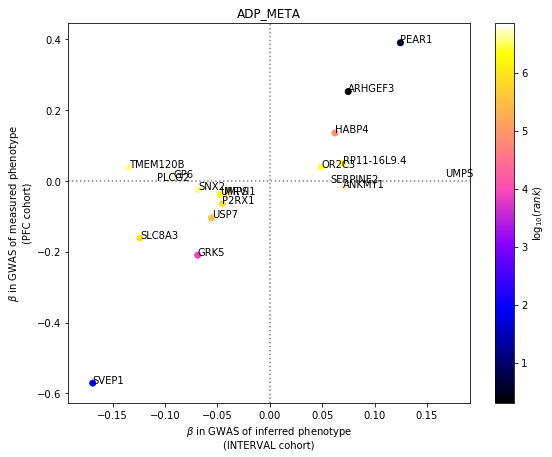

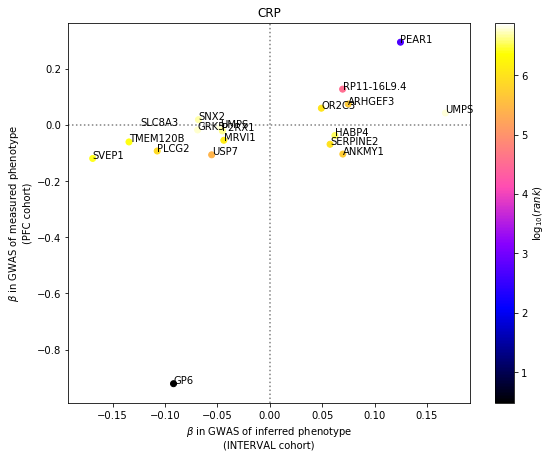

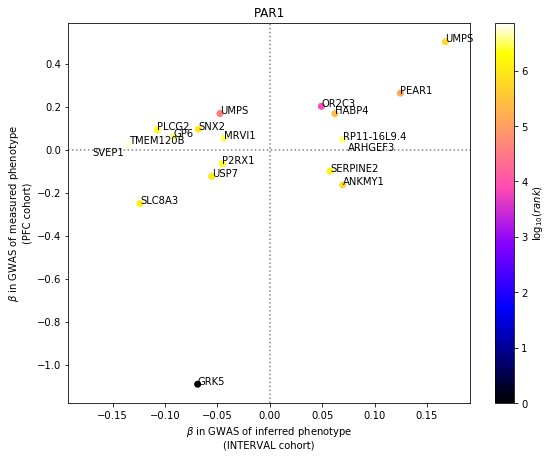

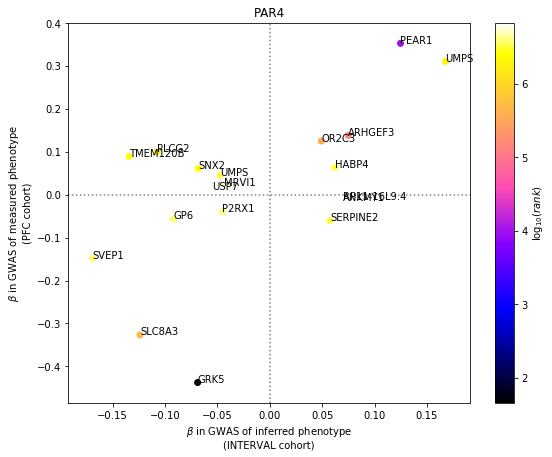

In [9]:
# missing : P2RX1, PLEKHO2, HLA-B & GP6
for ago in agonists:
    comp = pd.merge(bolt,pfc.loc[pfc.agonist == ago],how="inner",left_on="SNP",right_on="SNP")
    missing_SNPs = bolt.loc[~bolt.SNP.isin(comp.SNP.unique().tolist())].SNP.tolist()
    print("Missing for %s = " % ago)
    print(missing_SNPs)
    
    comp = pd.merge(comp, gwas_results[["SYMBOL","SNP","CHR"]], left_on="SNP",right_on="SNP")
    
    plt.figure(figsize=(9,7))
    plt.title(ago)
    cm = plt.scatter(comp["ADP_pred"],-comp["BETA"],c=np.log10(1.+comp["hit_rank"]),cmap="gnuplot2")
    for i, row in comp.iterrows():
        plt.text(row["ADP_pred"],-row["BETA"],row["SYMBOL"])
    plt.xlabel("$\\beta$ in GWAS of inferred phenotype\n(INTERVAL cohort)")
    plt.ylabel("$\\beta$ in GWAS of measured phenotype\n(PFC cohort)")
    plt.axvline(0,ls=':',c="grey")
    plt.axhline(0,ls=':',c="grey")
    plt.colorbar(cm,label="$\log_{10}(rank)$")
    
    

In [13]:
pfc_best_betas = pfc.sort_values("MLOG10P")\
    .groupby("ID")[["BETA","agonist","SE","MLOG10P"]].last()\
    .rename(columns={"BETA":"BETA_best_pval",
                     "agonist":"best_p_val_agonist",
                    "SE":"SE_best_pval",
                    "MLOG10P":"MLOG10P_best"})

In [14]:
pfc_best_betas.head()

,BETA_best_pval,best_p_val_agonist,SE_best_pval,MLOG10P_best
ID,,,,
10:100000625_A_G,-0.02535,CRP,0.04007,0.2781
10:100000645_A_C,-0.05695,ADP_META,0.04957,0.6010
10:100001867_C_T,-0.28830,ADP_META,0.19980,0.8271
10:100002464_T_C,0.69770,ADP_META,0.21400,2.9540
10:100003242_T_G,0.13490,ADP_META,0.06337,1.4770


In [15]:
pfc = pd.merge(pfc.loc[pfc.agonist == "ADP_META"].rename(columns={"BETA":"BETA_ADP"}),pfc_best_betas,left_on="ID",right_index=True)

In [16]:
# On met les betas de PFC à la place de ceux d' INTERVAL quand ils sont dispos
replaced = pd.merge(bolt,pfc,how="left",left_on="SNP",right_on="SNP")
replaced = pd.merge(replaced, gwas_results[["SNP","CHR"]],left_on="SNP",right_on="SNP")
replaced["BETA_merged"] = -replaced["BETA_ADP"]
missing = replaced.BETA_merged.isnull()

In [17]:
missing_SNPs = replaced.loc[missing,"SNP"].tolist()
print(missing_SNPs)

['rs3819288', 'rs59001897']


In [18]:
replaced.head(3)

,SNP,ALLELE1,ADP_pred,ID,RSID,CHR_x,POS,REF,ALT,AAF,...,MLOG10P,agonist,hit_rank,BP,BETA_best_pval,best_p_val_agonist,SE_best_pval,MLOG10P_best,CHR_y,BETA_merged
0,rs12566888,G,0.124800,1:156869047_G_T,rs12566888,1.0,156869047.0,G,T,0.08922,...,7.4970,ADP_META,3.0,156869047.0,-0.3907,ADP_META,0.07064,7.497,1,0.39070
1,rs1434282,C,0.069544,1:199010721_C_T,rs1434282,1.0,199010721.0,C,T,0.73110,...,0.5579,ADP_META,2108167.0,199010721.0,-0.1267,CRP,0.04456,2.349,1,0.05041
2,rs41315846,T,0.049249,1:247712303_T_C,rs41315846,1.0,247712303.0,T,C,0.46840,...,0.4738,ADP_META,2552431.0,247712303.0,-0.2024,PAR1,0.06177,2.978,1,0.03906


In [34]:
# Need to 
# 1) select SNPs in neighborhoods of missing SNPs
# 2) export genotypes to .bed format
# 3) use plink1.9 show-tags
n_splits = 32
for i, row in replaced.loc[missing].iterrows():
    SNP = row["SNP"]
    chrom = int(row["CHR_y"])
    snp_file = "/home/hv270/%s.txt" % SNP
    with open(snp_file,"w") as f:
        f.write(SNP)
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --snp %s --window 500" % SNP
    command += " --make-bed"
    command += " --out %s/tag_snps_PFC_interval/%s_neighborhood" % (export_folder, SNP)
    
    tag = "TAG"
    f_name = "/home/hv270/interval_slurm_calls/call_tag_chr_%s_%s.sh" % (SNP,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (SNP))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=0:30:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,SNP))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (SNP))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting rs3819288
Submitting rs59001897


In [35]:
# Remove duplicate SNPs
n_splits = 32
for i, row in replaced.loc[missing].iterrows():
    SNP = row["SNP"]
    chrom = int(row["CHR_y"])
    snp_file = "/home/hv270/%s.txt" % SNP
    with open(snp_file,"w") as f:
        f.write(SNP)
        
    command = "/home/hv270/plink2"
    command += " --bfile %s/tag_snps_PFC_interval/%s_neighborhood" % (export_folder, SNP)
    command += " --rm-dup force-first list"
    command += " --out %s/tag_snps_PFC_interval/%s_duplicates" % (export_folder, SNP)
    
    p = subprocess.Popen(command,shell=True)
    p.wait()

In [36]:
replacement = {}

In [37]:
# Find candidates
n_splits = 32
for i, row in replaced.loc[missing].iterrows():

    SNP = row["SNP"]
    if SNP in replacement: continue
    chrom = int(row["CHR_y"])
    pfc_snps = pfc.loc[pfc.CHR == chrom].RSID.unique().tolist()
    print(len(pfc_snps))
    assert len(pfc_snps) > 0
    snp_file = "/home/hv270/%s.txt" % SNP
    with open(snp_file,"w") as f:
        f.write(SNP)
    r2_threshold = .95
    while r2_threshold > 0:

        command = "/home/hv270/plink"
        command += " --bfile %s/tag_snps_PFC_interval/%s_neighborhood" % (export_folder, SNP)
        command += " --exclude %s/tag_snps_PFC_interval/%s_duplicates.rmdup.list" % (export_folder, SNP)
        command += " --show-tags %s --tag-r2 %.2f" % (snp_file, r2_threshold)
        command += " --out %s/tag_snps_PFC_interval/%s_tags" % (export_folder, SNP)

        p = subprocess.Popen(command,shell=True)
        p.wait()
        
        cnd = open("%s/tag_snps_PFC_interval/%s_tags.tags" % (export_folder, SNP),"r").readlines()
        cnd = [f[:-1] for f in cnd]
        print("%d snps in LD at r^2 = %.2f, looking if they are in PFC GWAS results" % (len(cnd),r2_threshold))
        assert len(cnd) > 0
        if any([snp in pfc_snps for snp in cnd]):
            print("OK for %s at R^2 = %.2f" % (SNP,r2_threshold))
            for snp in cnd:
                if snp in pfc_snps:
                    replacement[SNP] = snp
                    break
            break
        else:
            print("No replacement for %s wiht R^2 = %.2f" % (SNP,r2_threshold))
            r2_threshold -= 0.05

453770
2 snps in LD at r^2 = 0.95, looking if they are in PFC GWAS results
OK for rs3819288 at R^2 = 0.95
206762
2 snps in LD at r^2 = 0.95, looking if they are in PFC GWAS results
No replacement for rs59001897 wiht R^2 = 0.95
2 snps in LD at r^2 = 0.90, looking if they are in PFC GWAS results
No replacement for rs59001897 wiht R^2 = 0.90
19 snps in LD at r^2 = 0.85, looking if they are in PFC GWAS results
OK for rs59001897 at R^2 = 0.85


In [38]:
replacement

{'rs3819288': 'rs17881225', 'rs59001897': 'rs12905925'}

In [39]:
n_splits = 12
tag = "replace"
for to_replace, substitute in replacement.items():
    
    chrom = int(pfc.loc[pfc.RSID == substitute].CHR.values[0])
    snp_file = "/home/hv270/%s.txt" % substitute
    with open(snp_file,"w") as f:
        f.write(substitute)
    
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d_replacement" % (export_folder, chrom)
    
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --extract %s" % snp_file
    command += " --recode A-transpose --out %s" % gen_path
    
    f_name = "/home/hv270/interval_slurm_calls/call_beta_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=3:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 6
Submitting 15


In [ ]:
# MAKE 

In [15]:
snp_path = "%s/conditional_analysis/causal_SNPs_BOLT_%s_%s.txt" % (export_folder,tag,"ADP_pred")

In [17]:
assert len(open(snp_path).readlines()) == bolt.shape[0]

In [18]:
export_folder

'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing'

In [19]:
n_splits = 12
for chrom in np.arange(1,23):
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d" % (export_folder, chrom)
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --extract %s" % snp_path
    command += " --recode A-transpose --out %s" % gen_path
    
    f_name = "/home/hv270/interval_slurm_calls/call_beta_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=3:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22


## Read exports

### ... of INTERVAL SNPs

In [19]:
dfs = []
for chrom in np.arange(1,23):
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d" % (export_folder, chrom)
    try:
        dfs.append(pd.read_csv(gen_path + ".traw",sep="\t"))
    except FileNotFoundError:
        pass
df = pd.concat(dfs,axis=0)

IDs_cols = [c for c in df.columns if "_" in c]

In [20]:
dfs_rep = []
for chrom in np.arange(1,23):
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d_replacement" % (export_folder, chrom)
    try:
        dfs_rep.append(pd.read_csv(gen_path + ".traw",sep="\t"))
    except FileNotFoundError:
        pass

In [21]:
df_rep = pd.concat(dfs_rep,axis=0)

In [22]:
df.head(3)

,CHR,SNP,(C)M,POS,COUNTED,ALT,3988147_3988147,5152243_5152243,2770265_2770265,3790399_3790399,...,5373743_5373743,5330338_5330338,4861071_4861071,4101944_4101944,5838717_5838717,4494916_4494916,4272180_4272180,2654475_2654475,4943537_4943537,2379838_2379838
0,1,rs12566888,0,156869047,T,G,0,1.0,0.0,1.0,...,0.0,0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0
1,1,rs1434282,0,199010721,T,C,2,2.0,2.0,2.0,...,2.0,2,2.0,1.00000,0.95685,1.0,2.0,1.0,2.0,2
2,1,rs41315846,0,247712303,C,T,0,1.0,1.0,0.0,...,1.0,2,1.0,1.26666,1.00000,1.0,1.0,1.0,2.0,1


In [23]:
df_rep.head(3)

,CHR,SNP,(C)M,POS,COUNTED,ALT,3988147_3988147,5152243_5152243,2770265_2770265,3790399_3790399,...,5373743_5373743,5330338_5330338,4861071_4861071,4101944_4101944,5838717_5838717,4494916_4494916,4272180_4272180,2654475_2654475,4943537_4943537,2379838_2379838
0,6,rs17881225,0,31323065,C,G,0,0,0,0,...,1,0,0.0000,0,0,1,0,0,0,0
0,15,rs12905925,0,65164845,C,G,0,1,1,0,...,0,1,1.0157,0,0,1,0,0,1,0


In [24]:
df_all = pd.concat([df, df_rep], axis=0)

In [25]:
G = df_all.set_index("SNP")[IDs_cols].T

In [28]:
df_all.to_hdf("%s/df_all.hdf" % export_folder,key="df")
G.to_hdf("%s/G_UKBB.hdf" % export_folder,key="G")

## Read formatted exports

In [ ]:
df_all = pd.read_hdf("%s/df_all.hdf" % export_folder)
G = pd.read_hdf("%/G_UKBB.hdf" % export_folder)

In [29]:
pfc = pfc.merge(bolt.rename(columns={"ADP_pred":"BETA_INTERVAL","ALLELE1":"EFFECT_ALLELE_INTERVAL"}),left_on="SNP",right_on="SNP",how="left")

In [30]:
pfc = pfc.merge(df_all[["SNP","COUNTED"]].rename(
    columns={"COUNTED":"COUNTED_in_genotypes"}),
          left_on="SNP",right_on="SNP",how="left")

In [31]:
pfc.sample(3)

,ID,RSID,CHR,POS,REF,ALT,AAF,MINOR,MAF,ALT_MINOR,...,hit_rank,BP,SNP,BETA_best_pval,best_p_val_agonist,SE_best_pval,MLOG10P_best,EFFECT_ALLELE_INTERVAL,BETA_INTERVAL,COUNTED_in_genotypes
6611897,15:58201698_C_T,rs12440501,15,58201698,C,T,0.3955,T,0.3955,True,...,6611897,NaN,rs12440501,-0.09386,PAR1,0.06295,0.8667,NaN,NaN,NaN
3960570,18:3145167_C_T,rs7239441,18,3145167,C,T,0.1634,T,0.1634,True,...,3960570,NaN,rs7239441,-0.09114,PAR1,0.08676,0.5324,NaN,NaN,NaN
4105161,16:54447808_T_C,rs12708945,16,54447808,T,C,0.4239,C,0.4239,True,...,4105161,NaN,rs12708945,-0.13370,PAR4,0.06182,1.5140,NaN,NaN,NaN


In [32]:
replacement = {'rs3819288': 'rs17881225', 'rs59001897': 'rs12905925'}

In [33]:
interval_SNPs = bolt.SNP.unique().tolist()
pfc_SNPs = [c for c in interval_SNPs if c not in replacement] + [rep for tbr, rep in replacement.items()]

In [34]:
assert len(interval_SNPs) == len(pfc_SNPs)

In [35]:
pfc.loc[pfc.SNP.isin(pfc_SNPs)].best_p_val_agonist.value_counts()

CRP         8
ADP_META    6
PAR1        5
PAR4        2
Name: best_p_val_agonist, dtype: int64

In [36]:
from sklearn.linear_model import LinearRegression

In [39]:
for key, value in replacement.items():
    pfc.loc[pfc.SNP == value,"BETA_INTERVAL"] = bolt.loc[bolt.SNP == key,"ADP_pred"].values

In [40]:
pfc["homogenous_BETA"] = 0.
pfc["homogenous_SE"] = 0.

In [41]:
pfc.columns

Index(['ID', 'RSID', 'CHR', 'POS', 'REF', 'ALT', 'AAF', 'MINOR', 'MAF',
       'ALT_MINOR', 'REF_COUNT', 'ALT_COUNT', 'INFO', 'BETA_ADP', 'SE',
       'MLOG10P', 'agonist', 'hit_rank', 'BP', 'SNP', 'BETA_best_pval',
       'best_p_val_agonist', 'SE_best_pval', 'MLOG10P_best',
       'EFFECT_ALLELE_INTERVAL', 'BETA_INTERVAL', 'COUNTED_in_genotypes',
       'homogenous_BETA', 'homogenous_SE'],
      dtype='object')

In [42]:
significant = pfc.SNP.isin(pfc_SNPs)
for ago in pfc.best_p_val_agonist.unique().tolist():
    cond = significant & (pfc.best_p_val_agonist == ago)
    lm = LinearRegression(fit_intercept=False).fit(pfc.loc[cond,["BETA_best_pval"]],pfc.loc[cond,["BETA_INTERVAL"]])
    pfc.loc[cond,"homogenous_BETA"] = lm.predict(pfc.loc[cond,["BETA_best_pval"]])
    pfc.loc[cond,"homogenous_SE"] = lm.coef_[0,0]*pfc.loc[cond,["SE_best_pval"]].values

In [43]:
# Checked that counted allele is the opposite of interval effect allele
interval_score = (2-G[interval_SNPs]) @ bolt.set_index("SNP").loc[interval_SNPs,"ADP_pred"]

# Checked that in PFC, effect allele is the opposite as in interval, hence the same as the counted allele
adp_score = G[pfc_SNPs] @ pfc.set_index("SNP").loc[pfc_SNPs,"BETA_ADP"]
best_pval_score = G[pfc_SNPs] @ pfc.set_index("SNP").loc[pfc_SNPs,"BETA_best_pval"]
best_pval_score_homogenous = -G[pfc_SNPs] @ pfc.set_index("SNP").loc[pfc_SNPs,"homogenous_BETA"]

In [44]:
to_export = pd.DataFrame(index=interval_score.index)
to_export["INTERVAL_score"] = interval_score
to_export["ADP_score"] = adp_score
to_export["best_pval_score"] = best_pval_score
to_export["best_pval_score_homogenous"] = best_pval_score_homogenous

In [45]:
to_export.to_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder,key="scores")

# Plot

In [46]:
tag = "20_dec_21"
chr_group_files = glob("%s/%s/bolt_res_bgen_feb_ADP_pred_chr*" % (export_folder,tag))
bgs = []
for f in chr_group_files:
    df = pd.read_csv(f,sep="\t")
    assert df.isnull().sum(axis=0).sum() == 0
    bgs.append(df)
bg = pd.concat(bgs,axis=0).sort_values(["CHR","BP"])

In [47]:
bg.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P_BOLT_LMM
591379,rs367896724,1,10177,0,A,AC,0.623991,0.735090,0.267213,0.61,0.003642,0.008563,0.180860,0.67,0.208059,0.65
591380,rs145072688,1,10352,0,T,TA,0.622860,0.722254,0.759546,0.38,-0.007107,0.008604,0.682318,0.41,0.614900,0.43
591381,rs575272151,1,11008,0,C,G,0.915802,0.737639,0.654907,0.42,0.010514,0.014847,0.501494,0.48,0.647073,0.42
591382,rs544419019,1,11012,0,C,G,0.918340,0.730055,0.031515,0.86,0.000202,0.015148,0.000178,0.99,0.001427,0.97
591383,rs540538026,1,13110,0,G,A,0.942219,0.686493,0.007756,0.93,0.001711,0.018347,0.008700,0.93,0.002563,0.96


In [48]:
std = to_export["best_pval_score_homogenous"].std()

In [50]:
c = significant
comp = pfc.loc[c].copy().replace({"ADP_META":"ADP","CRP":"CRP-XL"})

comp = pd.merge(comp,gwas_results.replace(replacement),left_on="SNP",right_on="SNP",how="left")
comp = comp.merge(bg[["SNP","SE"]].rename(columns={"SE":"SE_INTERVAL"}),left_on="SNP",right_on="SNP")
comp[["homogenous_BETA","homogenous_SE","BETA_INTERVAL","SE_INTERVAL"]] /= std

comp = comp.replace({"OR2C3":"GCSAML"})

In [52]:
comp.to_hdf("%s/comp_fig3a.hdf" % export_folder,key="comp")

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/generic.py:2620: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['ID', 'RSID', 'REF', 'ALT', 'MINOR', 'agonist', 'SNP',
       'best_p_val_agonist', 'EFFECT_ALLELE_INTERVAL', 'COUNTED_in_genotypes',
       'ALLELE1', 'ALLELE0', 'pheno', '#Uploaded_variation', 'Location',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Gene', 'Feature_type',
       'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'HGVSc', 'HGVSp',
       'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids',
       'Codons', 'Existing_variation', 'DISTANCE', 'FLAGS', 'SYMBOL_SOURCE',
       'HGNC_ID', 'MANE_SELECT', 'MANE_PLUS_CLINICAL', 'TSL', 'APPRIS', 'SIFT',
       'PolyPhen', 'AF', 'CLIN_SIG', 'SOMATIC', 'PHENO', 'PUBMED',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE',
       'TRANSCRIPTION_F

## Start from pre-processed table

In [4]:
from matplotlib.patches import Ellipse

In [21]:
comp = pd.read_hdf("%s/comp_fig3a.hdf" % export_folder)\
    .replace({"RP11-16L9.4":"PTPRC",
              "OR2C3":"GCSAML",
              "ANKMY1":"RNPEPL1",
              "UMPS":"KALRN",
              "PIF1":"PLEKHO2",
              "TMEM120B":"RHOF"})
comp.to_csv("/home/hv270/sysmex2pf/figures/betas_info.csv")

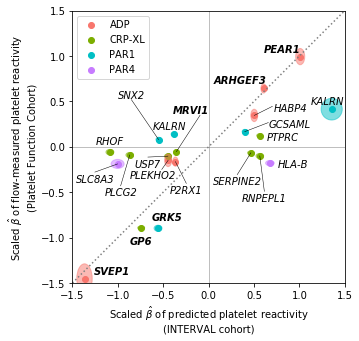

In [19]:
ells = {}
for i, row in comp.iterrows():
    ells[i] = Ellipse(xy=np.array([row["BETA_INTERVAL"],row["homogenous_BETA"]]),
                  angle = 0.,
                  width=row["SE_INTERVAL"],height=-1*row["homogenous_SE"])

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'},figsize=(5,5))

ax.axvline(0,ls='-',c="grey",lw=.5)
ax.axhline(0,ls='-',c="grey",lw=.5)
ax.plot([-1.5,1.5],[-1.5,1.5],ls=":",c="grey")

colors = {"ADP":"#F8766D","CRP-XL":"#7CAE00","PAR1":"#00BFC4","PAR4":"#C77CFF"}
for i, (ago, comp_) in enumerate(comp.groupby("best_p_val_agonist")):
    #ax1.scatter(comp_["BETA_INTERVAL"],-comp_["BETA_best_pval"],marker="*",label=ago,c=colors[i])
    ax.scatter(comp_["BETA_INTERVAL"],comp_["homogenous_BETA"],c=colors[ago],label=ago)
ax.legend()


known_genes = ["GP6","PEAR1","MRVI1","GRK5","ARHGEF3","SVEP1"]

shifts = {"GRK5":(.1,0.04),
          "SVEP1":(.1,0),
         "GP6":(0.,-.23),
         "HLA-B":(0.25,-.1),
         "SLC8A3":(-.25,-.25),
         "PTPRC":(.25,-.1),
          "HABP4":(.4,0.),
          "PLCG2":(-.1,-.5),
          "KALRN":(-.05,0.),
          "GCSAML":(.5,0.),
          "RHOF":(.0,.04),
          "SERPINE2":(-.15,-.4),
          "SNX2":(-.3,.4),
          "P2RX1":(0.12,-.4),
          "PLEKHO2":(-0.17,-.25),
          "USP7":(-0.22,-.17),
          "MRVI1":(.16,0.37),
          "SVEP1":(.3,0.),
          "ARHGEF3":(-.26,0.),
          "PEAR1":(-.2,0.),
         "RNPEPL1":(.05,-.55)}

to_link = ["RNPEPL1","SERPINE2","GCSAML","HABP4","PLCG2","SNX2","P2RX1","PLEKHO2","USP7","SLC8A3","MRVI1"]
link_shift = {"GCSAML":(-.24,.05),"HABP4":(-.2,.05),"SNX2":(0.,-.01),"MRVI1":(.1,-.02),"PLEKHO2":(.1,0.1)}
for i, row in comp.iterrows():
    
    #ax.add_artist(ells[i])
    ells[i].set_clip_box(ax.bbox)
    ells[i].set_alpha(.5)
    ago = row["best_p_val_agonist"]
    ells[i].set_facecolor(colors[ago])
    ells[i].set_edgecolor(colors[ago])
    weight = "bold" if row["SYMBOL"] in known_genes else None
    if row["SYMBOL"] in shifts:
        shift_x,shift_y = shifts[row["SYMBOL"]]
    else:
        shift_x,shift_y = 0,0
    ax.text(row["BETA_INTERVAL"]+shift_x,
            .05+row["homogenous_BETA"]+shift_y,row["SYMBOL"],
            ha="center",style="italic",weight=weight)
    if row["SYMBOL"] in to_link:
        shift_x_link, shift_y_link = 0., .11 
        if row["SYMBOL"] in link_shift:
            shift_x_link, shift_y_link = link_shift[row["SYMBOL"]]
        ax.plot([row["BETA_INTERVAL"],row["BETA_INTERVAL"]+shift_x+shift_x_link],
                [row["homogenous_BETA"],.05+row["homogenous_BETA"]+shift_y+shift_y_link],lw=.5,c="black")
    
ax.set_xlabel("Scaled $\hat{\\beta}$ of predicted platelet reactivity \n(INTERVAL cohort)")
ax.set_ylabel("Scaled $\hat{\\beta}$ of flow-measured platelet reactivity\n(Platelet Function Cohort)")

ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/betas.pdf")

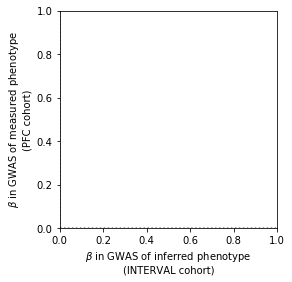

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse


# Fixing random state for reproducibility
np.random.seed(19680801)

NUM = 250

ells = [Ellipse(xy=np.array([row["BETA_INTERVAL"],row["homogenous_BETA"]]),#np.random.rand(2) * 10,
                angle = 0.,
                width=1.,height=row["homogenous_SE"])
        for i, row in comp.iterrows()]

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(np.random.rand())
    e.set_facecolor(np.random.rand(3))
    
ax.set_xlabel("$\\beta$ in GWAS of inferred phenotype\n(INTERVAL cohort)")
ax.set_ylabel("$\\beta$ in GWAS of measured phenotype\n(PFC cohort)")
ax.axvline(0,ls=':',c="grey")
ax.axhline(0,ls=':',c="grey")

plt.show()

In [188]:
comp[["best_p_val_agonist"]].replace({"ADP_META":"ADP"})

,best_p_val_agonist
0,ADP
1,ADP
2,ADP
3,PAR1
4,ADP
5,PAR4
6,CRP
7,ADP
8,PAR4
9,CRP


# Unused

In [113]:
X = G_merged.values

In [114]:
X = X - np.mean(X,axis=0)

In [115]:
X /= np.std(X,axis=0)

In [116]:
N = X.shape[0]

In [117]:
C = (1./N) * (X.T @ X)

In [118]:
np.fill_diagonal(C,0.)

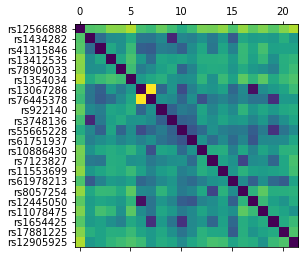

In [119]:
plt.matshow(np.log10(1e-4+np.abs(C)))
plt.yticks(np.arange(C.shape[0]),G_merged.columns);

(array([ 22.,   0.,   0.,   0.,   2.,  10.,  78., 230., 124.,  18.]),
 array([-7.        , -6.38976996, -5.77953993, -5.16930989, -4.55907986,
        -3.94884982, -3.33861979, -2.72838975, -2.11815971, -1.50792968,
        -0.89769964]),
 <a list of 10 Patch objects>)

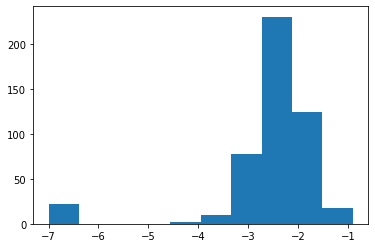

In [120]:
plt.hist(np.log10(1e-7 + np.abs(np.reshape(C,(-1,)))))

# Build score based on Top-22 Dragana's hits

## Export hits

In [174]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]
dgw.rename(columns={'(UNIVAR) -log10 P':"MLOG10P"},inplace=True)

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [181]:
dgw.columns

Index(['Associated Blood Index', 'Novel vs Astle 2016', 'Locus ID',
       'Associated Blood Index Class', 'Unique Variant ID', 'Gene', 'SNP',
       'INFO SCORE', 'Chr (GRCh37)', 'BP (GRCh37)', 'REF (GRC37)',
       'ALT (GRC37)', 'Minor Allele', 'Alternative Allele Frequency',
       'Minor Allele Frequency',
       '(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)',
       '(UNIVAR) Standard Error of Estimator', 'MLOG10P',
       '(UNIVAR) Unadjusted R2',
       '(MULTI) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)',
       '(MULTI) Standard Error of Estimate', '(MULTI) -log10 P',
       'Most Serious VEP Consequence of Variant',
       'VEP IMPACT of Most Serious Consequence',
       'Ensembl Gene ID(s) for Most Serious Consequence'],
      dtype='object')

In [219]:
top_draganas = dgw.loc[dgw["Minor Allele Frequency"] >= 0.01].sort_values("MLOG10P",ascending=False).groupby("SNP")[["Gene","Minor Allele Frequency","MLOG10P","Unique Variant ID"]].first().sort_values("MLOG10P",ascending=False).head(22)

In [220]:
top_draganas

,Gene,Minor Allele Frequency,MLOG10P,Unique Variant ID
SNP,,,,
rs11553699,"TMEM120B,RHOF",0.129690,3154.750012,12:122216910_A_G
rs463312,TUBB1,0.048016,2679.090323,20:57597970_A_C
rs1354034,ARHGEF3,0.395519,2579.524602,3:56849749_T_C
rs342293,CTB-111H14.1,0.454961,1413.487193,7:106372219_C_G
rs517967,TAOK1,0.485971,973.024590,17:27794988_T_G
rs6425522,DNM3,0.198844,802.923537,1:171946082_T_C
rs10761731,JMJD1C,0.419837,799.464216,10:65027610_A_T
rs78909033,RNPEPL1,0.135614,768.255237,2:241510903_G_A
rs9402686,HBS1L,0.271464,712.914670,6:135427817_G_A


In [221]:
dgw_pfc = pd.merge(top_draganas,pfc,left_on="Unique Variant ID",right_on="ID",suffixes=("_DGW","_PFC"),how="left")

In [222]:
dgw_pfc

,Gene,Minor Allele Frequency,MLOG10P_DGW,Unique Variant ID,ID,RSID,CHR,POS,REF,ALT,...,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA,SE,MLOG10P_PFC,hit_rank,BP,SNP
0,"TMEM120B,RHOF",0.129690,3154.750012,12:122216910_A_G,12:122216910_A_G,rs11553699,12,122216910,A,G,...,True,4758.2,733.8,0.8877,-0.037110,0.06418,0.24940,4249526,122216910.0,rs11553699
1,TUBB1,0.048016,2679.090323,20:57597970_A_C,20:57597970_A_C,rs463312,20,57597970,A,C,...,True,5242.0,250.0,1.0000,0.002972,0.09512,0.01096,7305326,NaN,rs463312
2,ARHGEF3,0.395519,2579.524602,3:56849749_T_C,3:56849749_T_C,rs1354034,3,56849749,T,C,...,False,2114.0,3378.0,1.0000,-0.252900,0.04050,9.37400,1,56849749.0,rs1354034
3,CTB-111H14.1,0.454961,1413.487193,7:106372219_C_G,7:106372219_C_G,rs342293,7,106372219,C,G,...,True,3080.0,2412.0,1.0000,0.025660,0.04213,0.26570,4094661,NaN,rs342293
4,TAOK1,0.485971,973.024590,17:27794988_T_G,17:27794988_T_G,rs517967,17,27794988,T,G,...,False,2680.7,2811.3,0.9982,0.031770,0.04056,0.36310,3280798,NaN,rs517967
5,DNM3,0.198844,802.923537,1:171946082_T_C,1:171946082_T_C,rs6425522,1,171946082,T,C,...,False,1107.7,4384.3,0.9838,-0.066880,0.05064,0.72920,1430435,NaN,rs6425522
6,JMJD1C,0.419837,799.464216,10:65027610_A_T,10:65027610_A_T,rs71476393,10,65027610,A,T,...,True,3242.0,2250.0,1.0000,0.104900,0.04123,1.96100,86342,NaN,rs71476393
7,RNPEPL1,0.135614,768.255237,2:241510903_G_A,2:241510903_G_A,rs78909033,2,241510903,G,A,...,True,4740.0,752.0,1.0000,0.019190,0.05880,0.12830,5595561,241510903.0,rs78909033
8,HBS1L,0.271464,712.914670,6:135427817_G_A,6:135427817_G_A,rs9402686,6,135427817,G,A,...,True,4008.0,1484.0,1.0000,-0.014510,0.04578,0.12420,5648952,NaN,rs9402686
9,None,0.311369,683.883782,9:4763491_G_A,9:4763491_G_A,rs12005199,9,4763491,G,A,...,True,3715.5,1776.5,0.9110,0.020940,0.04537,0.19090,4851676,NaN,rs12005199


In [226]:
rsIDs = set(dgw_pfc.RSID.unique().tolist() + dgw_pfc.SNP.unique().tolist())
print(len(rsIDs))

22


In [227]:
dgw_snp_path = "%s/DGW_top_snps.txt" % (export_folder)
with open(dgw_snp_path,"w") as f:
    for snp in rsIDs:
        f.write("%s\n" % snp)

In [230]:
n_splits = 12
for chrom in dgw_pfc.CHR.unique().tolist():
    gen_path = "%s/UKB_DGW_SNPS_genotypes/chr_%d" % (export_folder, chrom)
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --extract %s" % dgw_snp_path
    command += " --recode A-transpose --out %s" % gen_path
    
    f_name = "/home/hv270/interval_slurm_calls/call_beta_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=3:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 12
Submitting 20
Submitting 3
Submitting 7
Submitting 17
Submitting 1
Submitting 10
Submitting 2
Submitting 6
Submitting 9
Submitting 5
Submitting 11


## Read and build score

In [21]:
dfs = []
for f in glob("%s/UKB_DGW_SNPS_genotypes/chr_*.traw" % export_folder):
    df = pd.read_csv(f,sep="\t")
    dfs.append(df)
df = pd.concat(dfs,axis=0)

KeyboardInterrupt: 

In [ ]:
IDs_cols = [c for c in df.columns if "_" in c]

In [ ]:
G_dgw = df.set_index("SNP")[IDs_cols].T

In [22]:
G_dgw

SNP,rs12005199,rs77265585,rs10974808,rs11604127,rs463312,rs1354034,rs9311623,rs655029,rs78909033,rs34592828,...,rs998908,rs3184504,rs11553699,rs2038479,rs6425522,rs1768584,rs511515,rs34164109,rs9402686,rs342293
3988147_3988147,1.00000,0.0,0.0,0.0000,0.0,1.0,1.0,2.00000,0.0,0.0,...,0.0,1.0,0.00000,2.0000,2.0,2.0,1.0,0.0,0.0,1.0
5152243_5152243,2.00000,1.0,1.0,0.0000,0.0,1.0,2.0,2.00000,0.0,0.0,...,1.0,1.0,0.94507,1.0000,1.0,1.0,1.0,0.0,0.0,2.0
2770265_2770265,0.00000,0.0,0.0,0.0000,0.0,2.0,2.0,1.00000,0.0,0.0,...,0.0,2.0,0.00000,1.0039,1.0,1.0,0.0,0.0,0.0,1.0
3790399_3790399,0.00000,0.0,0.0,0.9961,0.0,2.0,2.0,0.97644,0.0,0.0,...,1.0,0.0,0.18430,2.0000,2.0,1.0,0.0,1.0,1.0,2.0
4681935_4681935,1.00000,1.0,1.0,0.0000,0.0,0.0,1.0,1.00000,0.0,0.0,...,1.0,1.0,0.00000,2.0000,2.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494916_4494916,1.95294,0.0,0.0,0.9961,0.0,1.0,1.0,1.99610,1.0,0.0,...,1.0,0.0,1.00390,1.0000,1.0,1.0,1.0,1.0,1.0,1.0
4272180_4272180,0.03530,0.0,1.0,0.0000,1.0,1.0,1.0,1.99210,0.0,0.0,...,0.0,2.0,1.12160,2.0000,2.0,1.0,1.0,0.0,0.0,0.0
2654475_2654475,0.00000,0.0,0.0,0.0000,0.0,2.0,2.0,1.00000,0.0,0.0,...,0.0,1.0,0.00000,2.0000,2.0,1.0,2.0,1.0,1.0,2.0
4943537_4943537,0.99210,0.0,0.0,0.9137,0.0,2.0,2.0,2.00000,0.0,0.0,...,0.0,2.0,1.00000,2.0000,2.0,0.0,2.0,0.0,0.0,0.0


In [23]:
dgw_betas = pfc.set_index("SNP").loc[G_dgw.columns,"BETA"]

(array([1., 1., 0., 0., 2., 4., 3., 7., 2., 1.]),
 array([-0.2529 , -0.21671, -0.18052, -0.14433, -0.10814, -0.07195,
        -0.03576,  0.00043,  0.03662,  0.07281,  0.109  ]),
 <a list of 10 Patch objects>)

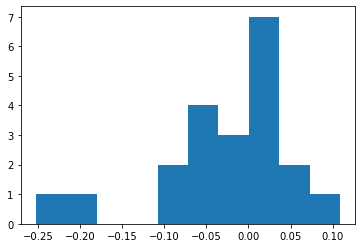

In [40]:
plt.hist(dgw_betas)

In [29]:
dgw_score = (2.-G_dgw) @ dgw_betas

# Re-Read PFC betas and compute scores

In [164]:
replaced_better = pd.merge(bolt.replace(replacement),pfc,how="left",left_on="SNP",right_on="SNP")
replaced_better = pd.merge(replaced_better, gwas_results[["SNP","CHR"]].replace(replacement),left_on="SNP",right_on="SNP",how="left")
replaced_better["BETA_merged"] = -replaced_better["BETA"]
missing = replaced_better.BETA_merged.isnull()
assert missing.sum() == 0

In [158]:
# missing : P2RX1, PLEKHO2, HLA-B & GP6
comp = pd.merge(bolt.replace(replacement),pfc,how="inner",left_on="SNP",right_on="SNP")
comp = pd.merge(comp, gwas_results[["SYMBOL","SNP","CHR"]].replace(replacement), left_on="SNP",right_on="SNP",how="left")

In [157]:
replacement

{'rs3819288': 'rs17881225', 'rs59001897': 'rs12905925'}

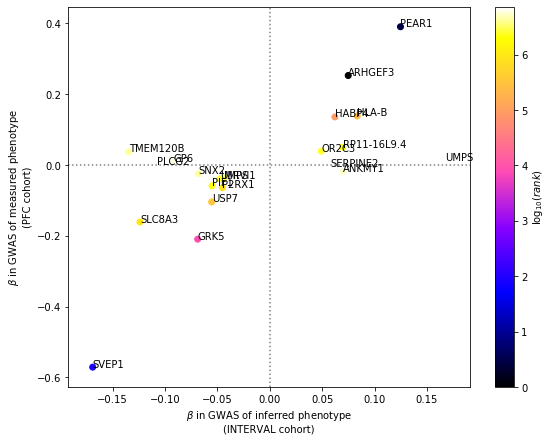

In [165]:
plt.figure(figsize=(9,7))
cm = plt.scatter(comp["ADP_pred"],-comp["BETA"],c=np.log10(comp["hit_rank"]),cmap="gnuplot2")
for i, row in comp.iterrows():
    if row["SYMBOL"]:
        plt.text(row["ADP_pred"],-row["BETA"],row["SYMBOL"])
plt.xlabel("$\\beta$ in GWAS of inferred phenotype\n(INTERVAL cohort)")
plt.ylabel("$\\beta$ in GWAS of measured phenotype\n(PFC cohort)")
plt.axvline(0,ls=':',c="grey")
plt.axhline(0,ls=':',c="grey")
plt.colorbar(cm,label="$\log_{10}(rank)$")

In [166]:
to_export = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder)

In [168]:
to_export.head()

SNP,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,rs1354034,rs13067286,rs76445378,rs922140,rs55665228,...,rs7123827,rs11553699,rs61978213,rs8057254,rs12445050,rs11078475,rs1654425,rs17881225,rs12905925,TOTAL
3988147_3988147,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.00000,...,1.0,0.00000,1.0,0.0,1.0,2.0,2.0,0.0,0.0,-0.162773
5152243_5152243,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.00000,...,0.0,0.94507,0.0,0.0,0.0,0.0,2.0,0.0,1.0,-0.172652
2770265_2770265,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,0.00000,...,2.0,0.00000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.417057
3790399_3790399,1.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.03925,...,1.0,0.18430,0.0,0.0,0.0,2.0,2.0,0.0,0.0,-0.629205
4681935_4681935,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,...,2.0,0.00000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.399746


In [169]:
to_export["TOTAL_PFC"] = (2 - to_export[replaced_better.SNP.tolist()].values) @ replaced_better[["BETA_merged"]].values

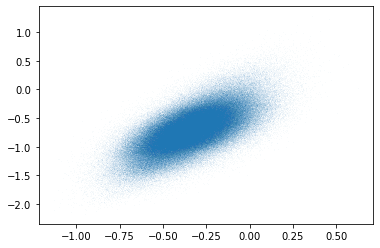

In [170]:
plt.scatter(to_export["TOTAL"],to_export["TOTAL_PFC"],s=.0001)

In [172]:
to_export[["TOTAL","TOTAL_PFC"]] -= to_export[["TOTAL","TOTAL_PFC"]].mean(axis=0)

In [173]:
to_export.to_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder, key="scores")

## Append DGW score to that

In [26]:
to_export = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder)

In [32]:
dgw_score_df = pd.DataFrame(dgw_score).rename(columns={0:"TOTAL_DGW"})

In [35]:
to_export = to_export.merge(dgw_score_df,left_index=True,right_index=True)

In [42]:
pearsonr(to_export["TOTAL_PFC"],to_export["TOTAL"])

(0.6679726703731929, 0.0)

In [41]:
pearsonr(to_export["TOTAL_PFC"],to_export["TOTAL_DGW"])

(-0.42775690080734524, 0.0)

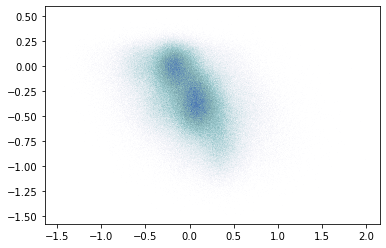

In [39]:
plt.scatter(to_export["TOTAL_PFC"],to_export["TOTAL_DGW"],s=.00001)

In [44]:
to_export

,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,rs1354034,rs13067286,rs76445378,rs922140,rs55665228,...,rs61978213,rs8057254,rs12445050,rs11078475,rs1654425,rs17881225,rs12905925,TOTAL,TOTAL_PFC,TOTAL_DGW
3988147_3988147,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.00000,...,1.0,0.0,1.0,2.0000,2.0,0.0,0.0,0.177452,0.098405,-0.617624
5152243_5152243,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.00000,...,0.0,0.0,0.0,0.0000,2.0,0.0,1.0,0.167572,0.322821,-0.424622
2770265_2770265,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,0.00000,...,0.0,0.0,0.0,1.0000,1.0,0.0,1.0,-0.076833,0.054766,-0.207040
3790399_3790399,1.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.03925,...,0.0,0.0,0.0,2.0000,2.0,0.0,0.0,-0.288981,-0.712958,-0.038376
4681935_4681935,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,...,0.0,0.0,0.0,1.0000,1.0,0.0,0.0,-0.059521,0.270382,-0.615097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494916_4494916,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.00000,...,0.0,1.0,0.0,0.0000,2.0,1.0,1.0,0.074731,0.002584,-0.660736
4272180_4272180,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.00000,...,0.0,1.0,1.0,0.0000,2.0,0.0,0.0,0.235833,-0.104498,-0.428407
2654475_2654475,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,0.00000,...,0.0,0.0,2.0,2.0000,2.0,0.0,0.0,0.270606,-0.065664,0.011453
4943537_4943537,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.00000,...,0.0,0.0,0.0,0.9843,2.0,0.0,1.0,0.046543,-0.275658,0.102257


In [43]:
to_export.to_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder, key="scores")